In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal
import os
import pandas as pd
from torch import nn
from scipy.spatial.distance import cdist
import spikeinterface.core as sc
import spikeinterface.full as si

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_gmm, plot_closest_spikes
from analysis.contrastive_utils import load_GPT_backbone
from analysis.cluster import GMM, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from analysis.cluster import MeanShift
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs
import matplotlib.patheffects as pe

from spike_psvae.denoise import SingleChanDenoiser

import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
ccolors = cc.glasbey[:31]

In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [4]:
is_multi_chan = True
if not is_multi_chan:
    data_path = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/single_channel/DY016_random_neurons/single_dy016_random_neurons_05_13_2023/')
else:
    # data_path = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/DO_NOT_USE_multi_dy016_random_neurons_04_28_2023/')
    data_path = Path('/moto/stats/users/ch3676/datasets_contrastive_ephys/multi_channel/DY016_random_neurons/multi_dy016_random_neurons_05_13_2023/')

In [5]:
# unit_ids = np.load(data_path / 'unit_ids.npy')
spikes_train_full = np.load(data_path / 'spikes_train.npy')
spikes_test_full = np.load(data_path / 'spikes_test.npy')
channel_spike_locs_train_full = np.load(data_path / 'channel_spike_locs_train.npy')
channel_spike_locs_test_full = np.load(data_path / 'channel_spike_locs_test.npy')
channel_num_train_full = np.load(data_path / 'channel_num_train.npy')
channel_num_test_full = np.load(data_path / 'channel_num_test.npy')
labels_test = np.load(data_path / 'labels_test.npy')
labels_train = np.load(data_path / 'labels_train.npy')
full_raw_spikes = np.load(data_path / 'full_raw_spikes.npy')
geom = np.load(data_path / 'geom.npy')

## Set PCA params

In [6]:
if spikes_train_full.shape[1] == 1 or len(spikes_train_full.shape) == 2:
    print("single channel waveforms")
    num_chan_pca = 1
    is_multi_chan = False
    if spikes_train_full.shape[1] == 1:
        spikes_train_full = spikes_train_full[:,0,:].astype('float32')
        spikes_test_full = spikes_test_full[:,0,:].astype('float32')
        channel_spike_locs_train_full = channel_spike_locs_train_full[:,0,:].astype('float32')
        channel_spike_locs_test_full = channel_spike_locs_test_full[:,0,:].astype('float32')
else:
    print("multi-channel waveforms")
    is_multi_chan = True

multi-channel waveforms


## Denoise

In [7]:
denoised_wfs_train_full = []
denoised_wfs_test_full = []

wfs_train_full = spikes_train_full.copy()
wfs_test_full = spikes_test_full.copy()

denoiser = SingleChanDenoiser()
denoiser.load('/moto/home/ch3676/spike-psvae/pretrained/single_chan_denoiser.pt')

k = 0
for i in tqdm(range(len(wfs_train_full))):
    curr_wf = wfs_train_full[i].astype('float32')
    with torch.no_grad():
        if not is_multi_chan:
            curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
            den_wf = denoiser(curr_wf)
        else:
            den_wf_ch_list = []
            for j, wf_ch in enumerate(curr_wf):
                wf_ch = torch.unsqueeze(torch.from_numpy(wf_ch), dim=0)
                den_wf_ch = denoiser(wf_ch)
                den_wf_ch_list.append(den_wf_ch)
            den_wf = torch.concatenate(den_wf_ch_list)
        denoised_wfs_train_full.append(den_wf.squeeze().numpy())
denoised_wfs_train_full = np.array(denoised_wfs_train_full)

for i in range(len(wfs_test_full)):
    curr_wf = wfs_test_full[i].astype('float32')
    with torch.no_grad():
        if not is_multi_chan:
            curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
            den_wf = denoiser(curr_wf)
        else:
            den_wf_ch_list = []
            for wf_ch in curr_wf:
                wf_ch = torch.unsqueeze(torch.from_numpy(wf_ch), dim=0)
                den_wf_ch = denoiser(wf_ch)
                den_wf_ch_list.append(den_wf_ch)
            den_wf = torch.concatenate(den_wf_ch_list)
        denoised_wfs_test_full.append(den_wf.squeeze().numpy())
denoised_wfs_test_full = np.array(denoised_wfs_test_full)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [8]:
n_comps = [3,5,7,9]
if not is_multi_chan:
    n_extra_chans_list = [0]
else:
    n_extra_chans_list = [1, 3, 5]

pca_list = [[] for i in range(len(n_extra_chans_list))]
denoised_pca_list = [[] for i in range(len(n_extra_chans_list))]
waveform_list = []
denoised_waveform_list = []
for i, num_extra_chans in enumerate(n_extra_chans_list):
    if is_multi_chan:
        wfs_train = wfs_train_full[:,wfs_train_full.shape[1]//2-num_extra_chans:wfs_train_full.shape[1]//2+num_extra_chans+1,:]
        wfs_test = wfs_test_full[:,wfs_test_full.shape[1]//2-num_extra_chans:wfs_test_full.shape[1]//2+num_extra_chans+1,:]
        denoised_wfs_train = denoised_wfs_train_full[:,denoised_wfs_train_full.shape[1]//2-num_extra_chans:denoised_wfs_train_full.shape[1]//2+num_extra_chans+1,:]
        denoised_wfs_test = denoised_wfs_test_full[:,denoised_wfs_test_full.shape[1]//2-num_extra_chans:denoised_wfs_test_full.shape[1]//2+num_extra_chans+1,:]
        channel_spike_locs_train = channel_spike_locs_train_full[:,channel_spike_locs_train_full.shape[1]//2-num_extra_chans:channel_spike_locs_train_full.shape[1]//2+num_extra_chans+1,:]
        channel_spike_locs_test = channel_spike_locs_test_full[:,channel_spike_locs_test_full.shape[1]//2-num_extra_chans:channel_spike_locs_test_full.shape[1]//2+num_extra_chans+1,:]
        channel_num_train = channel_num_train_full[:,channel_num_train_full.shape[1]//2-num_extra_chans:channel_num_train_full.shape[1]//2+num_extra_chans+1]
        channel_num_test = channel_num_test_full[:,channel_num_test_full.shape[1]//2-num_extra_chans:channel_num_test_full.shape[1]//2+num_extra_chans+1]
    else:
        wfs_train = wfs_train_full
        wfs_test = wfs_test_full
        denoised_wfs_train = denoised_wfs_train_full
        denoised_wfs_test = denoised_wfs_test_full
        channel_spike_locs_train = channel_spike_locs_train_full
        channel_spike_locs_test = channel_spike_locs_test_full
        channel_num_train = channel_num_train_full
        channel_num_test = channel_num_test_full
    
    waveform_list.append((wfs_train, wfs_test))
    denoised_waveform_list.append((denoised_wfs_train, denoised_wfs_test))
    
    print(f"train waveforms: {wfs_train.shape}")
    #compute PCA
    wfs_train_mean = np.mean(np.array([wf.flatten() for wf in wfs_train]), axis=0)
    wfs_train_norm = np.array([wf.flatten() for wf in wfs_train]) - wfs_train_mean
    wfs_test_norm = np.array([wf.flatten() for wf in wfs_test]) - wfs_train_mean
    denoised_wfs_train_mean = np.mean(np.array([wf.flatten() for wf in denoised_wfs_train]), axis=0)
    denoised_wfs_train_norm = np.array([wf.flatten() for wf in denoised_wfs_train]) - denoised_wfs_train_mean
    denoised_wfs_test_norm = np.array([wf.flatten() for wf in denoised_wfs_test]) - denoised_wfs_train_mean
    for n_comp in n_comps:
        pcs_train, _, _ = pca(wfs_train_norm, n_comp)
        pcs_test, pcs_ex_var  = pca_train(wfs_train_norm, wfs_test_norm, n_comp)
        pca_list[i].append((pcs_train, pcs_test))
        denoised_pcs_train, _, _  = pca(denoised_wfs_train_norm, n_comp)
        denoised_pcs_test, denoised_pcs_ex_var = pca_train(denoised_wfs_train_norm, denoised_wfs_test_norm, n_comp)
        denoised_pca_list[i].append((denoised_pcs_train, denoised_pcs_test))

train waveforms: (12000, 3, 121)
train waveforms: (12000, 7, 121)
train waveforms: (12000, 11, 121)


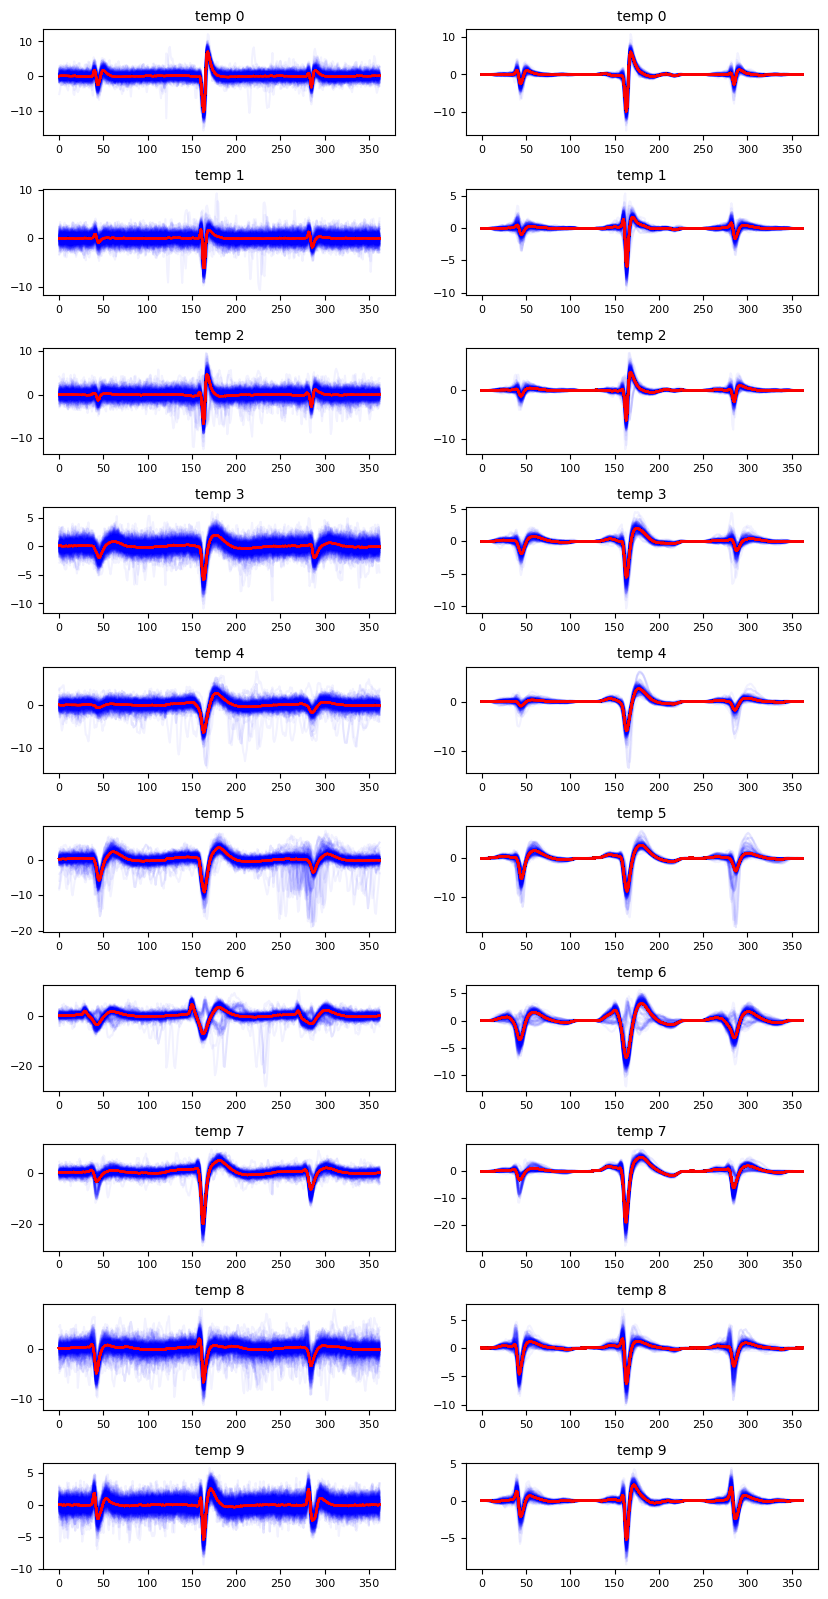

In [9]:
num_plot = 200
fig, axes = plt.subplots(10,2,figsize=(10,20))
num_extra_chans_idx = 0

for label_plot in range(len(np.unique(labels_train))):
    ax = axes[label_plot][0]
    spikes = waveform_list[0][0][np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')

for label_plot in range(len(np.unique(labels_test))):
    ax = axes[label_plot][1]
    spikes = denoised_waveform_list[0][0][np.where(labels_train==label_plot)]
    for spike in spikes[:num_plot]:
        ax.plot(spike.flatten(), color='blue', alpha=.05)
        ax.plot(np.mean(spikes, 0).flatten(), color='red')
    ax.set_title(f'temp {label_plot}')
fig.subplots_adjust(hspace=0.5)
plt.show()

In [77]:
n_extra_chans_list

[1, 3, 5]

In [78]:
from analysis.cluster import KMeansClustering, GMM, HDBSCAN, HDBSCAN_assign_outliers, MeanShift
pca_labels = []
denoised_pca_labels = []
'cont5'
pca_models = ['pc3', 'pc5', 'pc7', 'pc9']
den_pca_models = ['den_pc3', 'den_pc5', 'den_c7', 'den_pc9']
pca_scores = []
denoised_pca_scores = []
for j, n_extra_chans in enumerate(n_extra_chans_list[:1]):
    scores = []
    den_scores = []
    for n_clusters in np.arange(10)+1:
        model_params = {'n_clusters': n_clusters}
        pca_gmm_scores = avg_class_accs([x[0] for x in pca_list[j]], [x[1] for x in pca_list[j]], pca_models, mod_type='gmm', num_classes=10, labels_train=labels_train, labels_test=labels_test, model_params=model_params)
        den_pca_gmm_scores = avg_class_accs([x[0] for x in denoised_pca_list[j]], [x[1] for x in denoised_pca_list[j]], den_pca_models, mod_type='gmm', num_classes=10, labels_train=labels_train, labels_test=labels_test, model_params=model_params)
        scores.append(pca_gmm_scores)
        den_scores.append(den_pca_gmm_scores)

In [86]:
accs = []
bic_train_list = []
bic_test_list = []
for score in scores:
    acc = score['pc3']['score']
    bic_test = score['pc3']['bic_test']
    bic_train = score['pc3']['bic_train']
    accs.append(acc)
    bic_test_list.append(bic_test)
    bic_train_list.append(bic_train)

/tmp/ipykernel_334366/919256892.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  arr.set_yticklabels(arr.get_yticks()/1e4,fontsize=12)


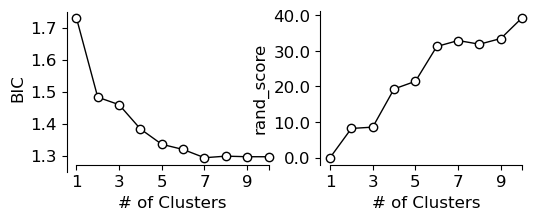

In [117]:
f, axes = plt.subplots(1,2)
f.set_size_inches(6., 2.)

arr = axes[0]
arr.plot(bic_test_list,c='k',
            marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)

arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xlabel('# of Clusters', fontsize=12)
arr.set_xticks([0,2,4,6,8,9])
arr.set_xticklabels([1,3,5,7,9,''],fontsize=12)
arr.set_ylabel('BIC', fontsize=12)
arr.set_yticklabels(arr.get_yticks()/1e4,fontsize=12)
arr.spines['left'].set_bounds(12500,17500)
arr.spines['bottom'].set_bounds(0,9)

arr = axes[1]
arr.plot(accs,c='k',
         marker='o',fillstyle='full',markerfacecolor='w',linewidth=1,markeredgewidth=1)

arr.spines['top'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xlabel('# of Clusters', fontsize=12)
arr.set_xticks([0,2,4,6,8,9])
arr.set_xticklabels([1,3,5,7,9,''],fontsize=12)
arr.set_ylabel('rand_score', fontsize=12)
arr.set_yticklabels(arr.get_yticks(),fontsize=12)
# arr.spines['left'].set_bounds(12500,14500)
arr.spines['bottom'].set_bounds(0,9)


In [111]:
arr.get_yticks()

array([-10.,   0.,  10.,  20.,  30.,  40.,  50.])

In [74]:
from analysis.cluster import KMeansClustering, GMM, HDBSCAN, HDBSCAN_assign_outliers, MeanShift
pca_labels = []
denoised_pca_labels = []
pca_models = ['pc3', 'pc5', 'pc7', 'pc9']
den_pca_models = ['den_pc3', 'den_pc5', 'den_c7', 'den_pc9']
pca_scores = []
denoised_pca_scores = []
for j, n_extra_chans in enumerate(n_extra_chans_list):
    pca_gmm_scores = avg_class_accs([x[0] for x in pca_list[j]], [x[1] for x in pca_list[j]], pca_models, mod_type='gmm', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    pca_hdb_scores = avg_class_accs([x[0] for x in pca_list[j]], [x[1] for x in pca_list[j]], pca_models, mod_type='hdbscan', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    # pca_mlp_scores = avg_class_accs([x[0] for x in pca_list[j]], [x[1] for x in pca_list[j]], pca_models, mod_type='mlp', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    print(f'{n_extra_chans} exchan, gmm', pca_gmm_scores)
    print(f'{n_extra_chans} exchan, hdb', pca_hdb_scores)
    # print(f'{n_extra_chans} exchan, mlp', pca_mlp_scores)
    pca_scores.append((pca_gmm_scores, pca_hdb_scores))#, pca_mlp_scores))
    
    den_pca_gmm_scores = avg_class_accs([x[0] for x in denoised_pca_list[j]], [x[1] for x in denoised_pca_list[j]], den_pca_models, mod_type='gmm', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    den_pca_hdb_scores = avg_class_accs([x[0] for x in denoised_pca_list[j]], [x[1] for x in denoised_pca_list[j]], den_pca_models, mod_type='hdbscan', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    # den_pca_mlp_scores = avg_class_accs([x[0] for x in denoised_pca_list[j]], [x[1] for x in denoised_pca_list[j]], den_pca_models, mod_type='mlp', num_classes=10, labels_train=labels_train, labels_test=labels_test)
    print(f'{n_extra_chans} exchan, gmm', den_pca_gmm_scores)
    print(f'{n_extra_chans} exchan, hdb', den_pca_hdb_scores)
    # print(f'{n_extra_chans} exchan, mlp', den_pca_mlp_scores)
    denoised_pca_scores.append((den_pca_gmm_scores, den_pca_hdb_scores))#, den_pca_mlp_scores))

NameError: name 'barf' is not defined

In [75]:
pca_gmm_scores

{'pc3': {'score': 39.29913297246891,
  'bic_test': 12965.615309125247,
  'bic_train': 73273.7747520288},
 'pc5': {'score': 57.21055525166332,
  'bic_test': 21457.329217455845,
  'bic_train': 119880.59794660358},
 'pc7': {'score': 55.293856096432734,
  'bic_test': 31131.236421558646,
  'bic_train': 171995.4753189268},
 'pc9': {'score': 51.448842215850874,
  'bic_test': 42218.92569673383,
  'bic_train': 230598.9610496697}}

In [67]:
pca_scores

[({'pc3': {'score': 39.29913297246891},
   'pc5': {'score': 57.21055525166332},
   'pc7': {'score': 55.293856096432734},
   'pc9': {'score': 51.448842215850874}},
  {'pc3': {'score': 77.3},
   'pc5': {'score': 88.25},
   'pc7': {'score': 92.75},
   'pc9': {'score': 92.85}}),
 ({'pc3': {'score': 44.733162148927946},
   'pc5': {'score': 48.47743779011581},
   'pc7': {'score': 51.9211501998171},
   'pc9': {'score': 48.442142167085684}},
  {'pc3': {'score': 78.0},
   'pc5': {'score': 85.65},
   'pc7': {'score': 89.35},
   'pc9': {'score': 92.4}}),
 ({'pc3': {'score': 41.91078684690414},
   'pc5': {'score': 37.1478519731258},
   'pc7': {'score': 43.39481028034288},
   'pc9': {'score': 43.34456053886198}},
  {'pc3': {'score': 80.75},
   'pc5': {'score': 88.35},
   'pc7': {'score': 91.64999999999999},
   'pc9': {'score': 93.8}})]

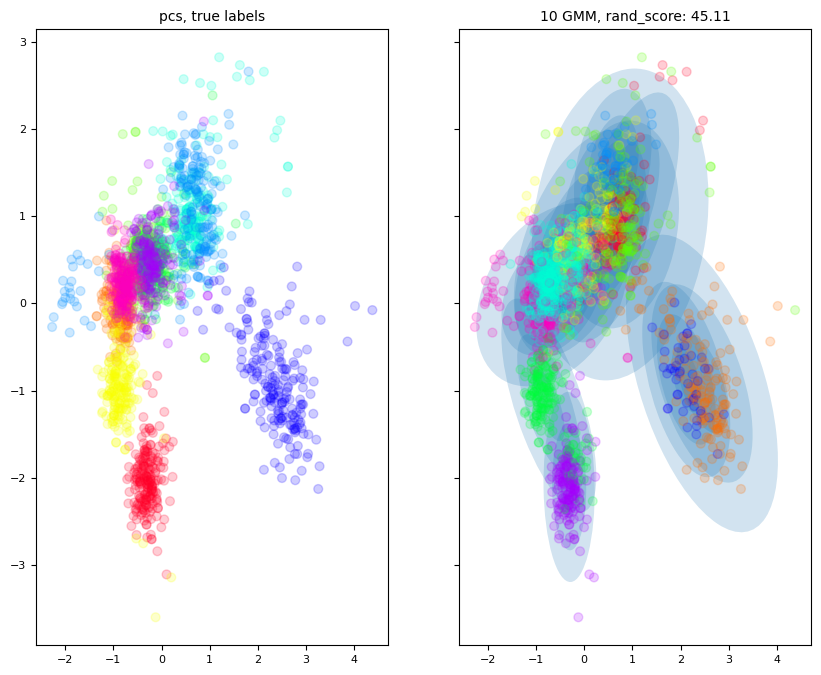

In [19]:
#GMM test example
reps_train = denoised_pca_list[2][1][0]
reps_test = denoised_pca_list[2][1][1]

num_components = reps_train.shape[1]
covariance_type = 'full'
n_clusters = 10
gmm = GaussianMixture(n_clusters, random_state=0, 
                      covariance_type=covariance_type).fit(reps_train[:,:num_components])
pc_test_labels = gmm.predict(reps_test[:,:num_components])

fig, axes = plt.subplots(1,2,figsize=(10,8), sharex=True, sharey=True)
X = reps_test[:,:num_components]
score = adjusted_rand_score(labels_test, pc_test_labels)*100
row = 0
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.2)
plot_gmm(gmm, X, label=True, ax=axes[1])
axes[0].set_title('pcs, true labels')
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,2)}');

In [21]:
# load representations
if not is_multi_chan:
    ckp_path = '/moto/stats/users/ch3676/datasets_contrastive_ephys/model_ckpts/spike_single_models_0509/0509out_dim512proj_dim5batch-size512lr0.001epochs800fp16use_gptis_causaln_embd32add_traindropout0.0/'
    path_to_reps = Path(ckp_path)
else:
    ckp_path = '/moto/stats/users/ch3676/datasets_contrastive_ephys/model_ckpts/spike_poschan_models_0514/0513_outdim5proj5_mc_gpt_conseq_causal_nembd64_block1342_bs128_extra5_lr0.0001_knn10_addtrain_concatpos/'
    path_to_reps = Path(ckp_path)

use_reps = True
if use_reps:
    cont_reps_train = torch.load(path_to_reps / 'train_reps_ep400.pt', map_location='cpu').numpy()
    cont_reps_test = torch.load(path_to_reps / 'test_reps_ep400.pt', map_location='cpu').numpy()
else:
    cont_reps_train = torch.load(path_to_reps / 'train_aftproj_reps_ep400.pt', map_location='cpu').numpy()
    cont_reps_test = torch.load(path_to_reps / 'test_aftproj_reps_ep400.pt', map_location='cpu').numpy()

In [28]:
from sklearn.mixture import GaussianMixture
import hdbscan
import numpy as np
from sklearn.metrics import adjusted_rand_score

covariance_type = 'full'
n_clusters = 10
reps_train = cont_reps_train
reps_test = cont_reps_test
gmm = GaussianMixture(n_clusters, 
                      random_state=0, 
                      covariance_type=covariance_type).fit(reps_train)
gmm_cont_test_labels = gmm.predict(reps_test)
score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
print(f"num_comps: {cont_reps_train.shape[1]}, rand_score: {score}")

num_comps: 5, rand_score: 95.6645200822896


In [27]:
#visualize aug representations in 2D pca
pcs_train_cont, _, _ = pca(cont_reps_train, n_comps=2)
pcs_test_cont, _  = pca_train(cont_reps_train, cont_reps_test, n_comps=2)

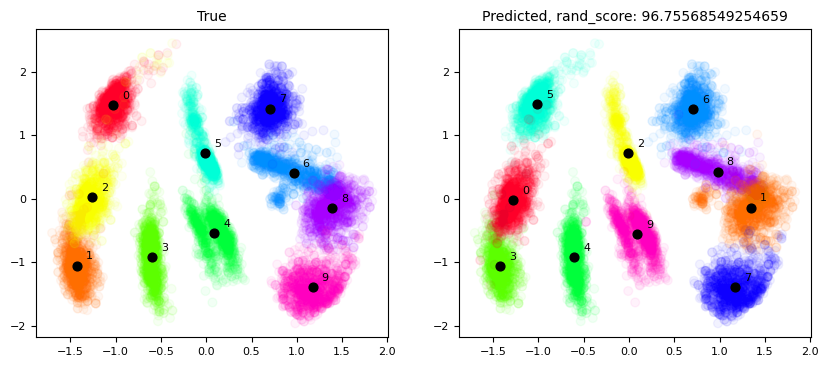

In [40]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_train_cont
train_labels = gmm.predict(cont_reps_train)
unit_id = 8
annotate_offset = .1
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=train_labels, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
for label_plot in range(len(np.unique(train_labels))):
    mean_location = np.mean(X[np.where(train_labels==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
    
for label_plot in range(len(np.unique(labels_train))):
    mean_location = np.mean(X[np.where(labels_train==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
    
score = adjusted_rand_score(labels_train, train_labels)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [63]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(cont_reps_test)
labels_hdb_test = clusterer.labels_
print(adjusted_rand_score(labels_test, labels_hdb_test)*100)

89.08901084963935


In [64]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer.fit(cont_reps_train)
labels_hdb_train = clusterer.labels_
adjusted_rand_score(labels_train, labels_hdb_train)*100

90.67743930451569

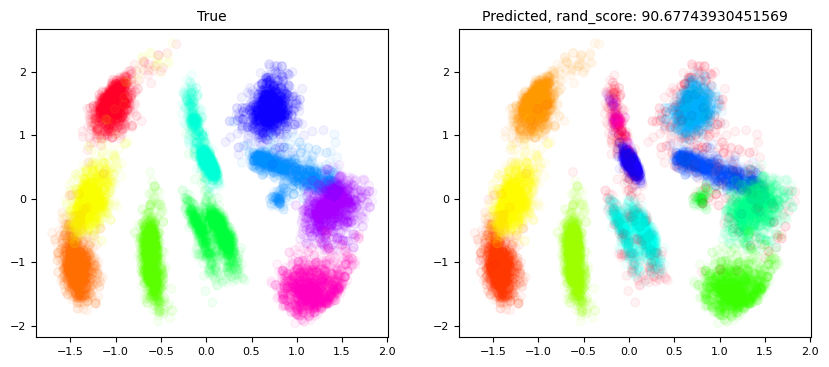

In [65]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_train_cont
gmm = gmm_list_cont[-1]
train_labels = gmm.predict(cont_reps_train)
unit_id = 8
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_hdb_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)

# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
# gmm_cont_test_labels = gmm.predict(cont_reps_test)
score = adjusted_rand_score(labels_train, labels_hdb_train)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

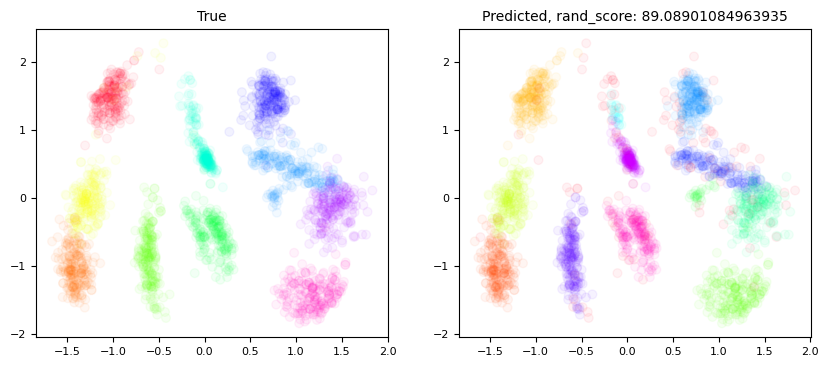

In [66]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = pcs_test_cont
gmm = gmm_list_cont[-1]
train_labels = gmm.predict(cont_reps_test)
unit_id = 8
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_hdb_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)

# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
# gmm_cont_test_labels = gmm.predict(cont_reps_test)
score = adjusted_rand_score(labels_test, labels_hdb_test)*100
axes[0].set_title('True')
axes[1].set_title(f'Predicted, rand_score: {score}');

In [50]:
neuron_locs = []
for label in np.unique(labels_train):
    neuron_locs.append((np.mean(channel_spike_locs_train[np.where(labels_train==label)][:,10],0)))
neuron_locs = np.asarray(neuron_locs)

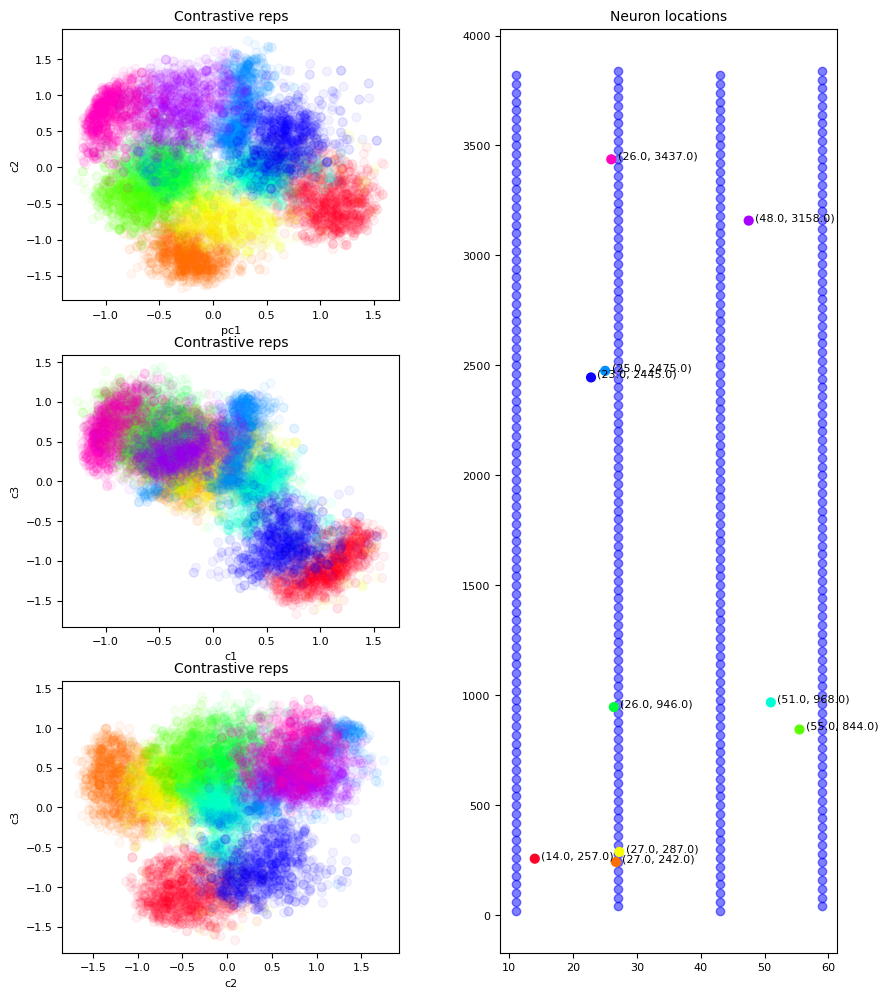

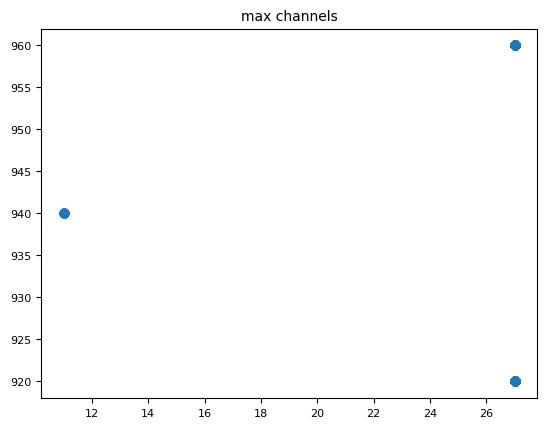

In [51]:
import matplotlib.gridspec as gridspec

# fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1,1]})
X = cont_reps_train
# gmm = gmm_list_cont[-1]
train_labels = gmm.predict(cont_reps_train)

# Create the figure and gridspec
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

# Plot on axes[0]
axes0 = fig.add_subplot(gs[0, 0])
axes0.scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes0.set_title('Contrastive reps')
axes0.set_xlabel('pc1')
axes0.set_ylabel('c2')

axes01 = fig.add_subplot(gs[1, 0])
axes01.scatter(X[:, 0], X[:, 2], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes01.set_title('Contrastive reps')
axes01.set_xlabel('c1')
axes01.set_ylabel('c3')

axes02 = fig.add_subplot(gs[2, 0])
axes02.scatter(X[:, 1], X[:, 2], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.05)
axes02.set_title('Contrastive reps')
axes02.set_xlabel('c2')
axes02.set_ylabel('c3')

# Plot on axes[1]
axes1 = fig.add_subplot(gs[:, 1])
axes1.scatter(neuron_locs[:, 0], neuron_locs[:, 1], c=np.unique(labels_train), s=40, cmap='gist_rainbow', zorder=2)
axes1.scatter(geom[:, 0], geom[:, 1], c='blue', zorder=1, alpha=.5)
for neuron_loc in neuron_locs:
    axes1.annotate(f'{np.round(neuron_loc[0], 0), np.round(neuron_loc[1], 0)}', (neuron_loc[0] + 1, neuron_loc[1] + 1), zorder=2)
axes1.set_title('Neuron locations')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()
plt.title('max channels')
mcs_temp = channel_spike_locs_train[np.where(labels_train==4)][:,10]
plt.scatter(mcs_temp[:,0], mcs_temp[:,1])

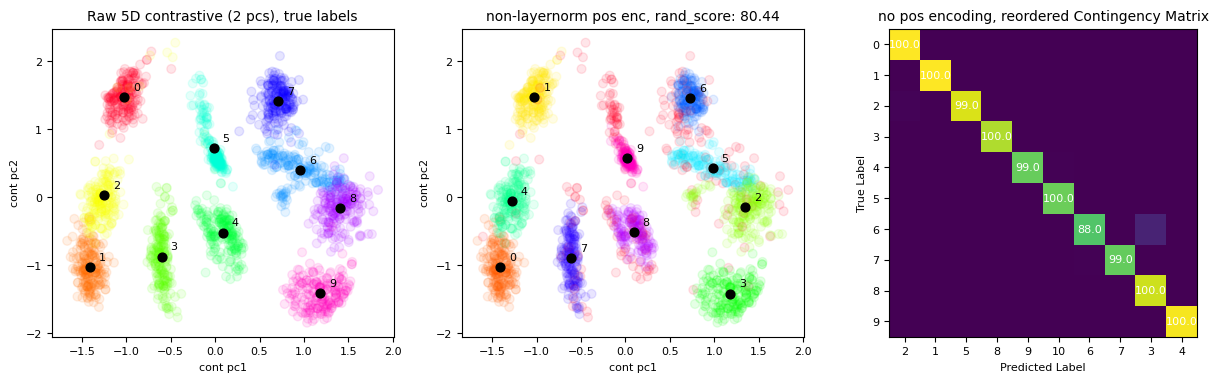

In [53]:
X = pcs_test_cont
labels_pred = labels_hdb_test
annotate_offset = .1
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'non-layernorm pos enc, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');


import numpy as np
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

#get contigency matrix
cont_matrix = contingency_matrix(labels_test, labels_pred)

# Reorder the contingency matrix using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-cont_matrix)
reordered_matrix = cont_matrix[row_ind][:, col_ind]

axes[2].imshow(reordered_matrix)
axes[2].set_xticks(range(len(col_ind)), col_ind)
axes[2].set_yticks(range(len(row_ind)), row_ind)
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('no pos encoding, reordered Contingency Matrix');
# Annotate diagonal values
for i in range(len(col_ind)):
    value = reordered_matrix[i, i] / np.sum(reordered_matrix[i]) * 100
    axes[2].text(i, i, str(np.round(value,0)), ha='center', va='center', color='white')

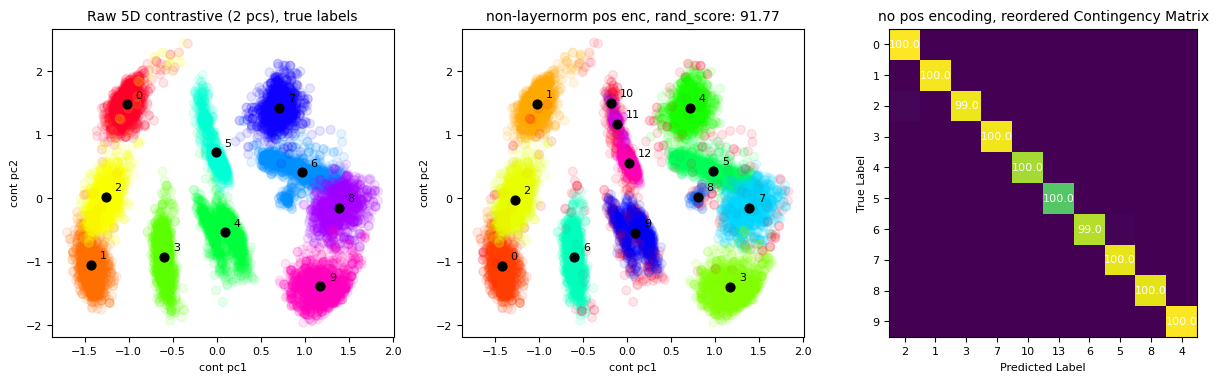

In [62]:
X = pcs_train_cont
labels_pred = labels_hdb_train
annotate_offset = .1
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_train))):
    mean_location = np.mean(X[np.where(labels_train==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_train, labels_pred)*100
axes[1].set_title(f'non-layernorm pos enc, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');


import numpy as np
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

#get contigency matrix
cont_matrix = contingency_matrix(labels_train, labels_pred)

# Reorder the contingency matrix using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-cont_matrix)
reordered_matrix = cont_matrix[row_ind][:, col_ind]

axes[2].imshow(reordered_matrix)
axes[2].set_xticks(range(len(col_ind)), col_ind)
axes[2].set_yticks(range(len(row_ind)), row_ind)
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title('no pos encoding, reordered Contingency Matrix');
# Annotate diagonal values
for i in range(len(col_ind)):
    value = reordered_matrix[i, i] / np.sum(reordered_matrix[i]) * 100
    axes[2].text(i, i, str(np.round(value,0)), ha='center', va='center', color='white')

In [73]:
 adjusted_rand_score(labels_test[np.where(labels_hdb_test != -1)], labels_hdb_test[np.where(labels_hdb_test != -1)])*100

97.78499543524379

In [74]:
 adjusted_rand_score(labels_train[np.where(labels_hdb_train != -1)], labels_hdb_train[np.where(labels_hdb_train != -1)])*100

93.03607862046218

In [29]:
np.where(labels_hdb_test != -1)

(array([   0,    1,    2, ..., 1997, 1998, 1999]),)

In [ ]:
score = adjusted_rand_score(labels_test, labels_test_ms)*100


In [205]:
contingency_matrix(labels_test, labels_pred)
labels=np.argsort(contingency_matrix(labels_test, labels_pred)[:,1])

array([[ 59,   0,   0,   0,   0, 239,   0,   0,   0,   2],
       [  9,   0,   0,   0,   0,   0,   0,   0,   0, 291],
       [ 37,   0,   0,   0,   0,   4,   0,   0,   0, 259],
       [  0,   0,   0,   0,  10,   0,   0, 290,   0,   0],
       [  0,   0,   1,   0, 298,   0,   0,   1,   0,   0],
       [  0,   0, 270,   0,  30,   0,   0,   0,   0,   0],
       [  0,   0,   0, 293,   0,   0,   7,   0,   0,   0],
       [  0,   0,   0,   9,   0,   0, 291,   0,   0,   0],
       [  0, 300,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 300,   0]])

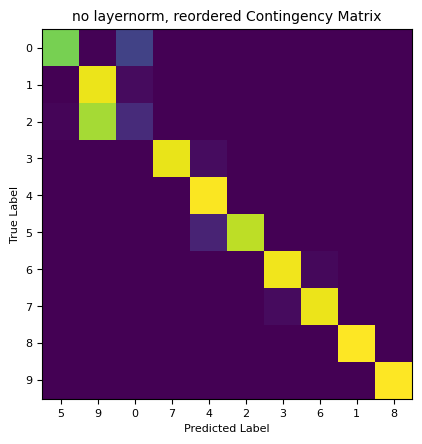

In [214]:
import numpy as np
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

#get contigency matrix
cont_matrix = contingency_matrix(labels_test, labels_pred)

# Reorder the contingency matrix using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-cont_matrix)
reordered_matrix = cont_matrix[row_ind][:, col_ind]

plt.imshow(reordered_matrix)
plt.xticks(range(len(col_ind)), col_ind)
plt.yticks(range(len(row_ind)), row_ind)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('no layernorm, reordered Contingency Matrix');

In [208]:
col_ind

array([5, 9, 0, 7, 4, 2, 3, 6, 1, 8])

In [694]:
from sklearn.manifold import TSNE


In [700]:
cont_train_umap = learn_manifold_umap(cont_reps_train, umap_dim=2, umap_min_dist=0.5, umap_metric='euclidean', umap_neighbors=10)
cont_test_umap = learn_manifold_umap(cont_reps_test, umap_dim=2, umap_min_dist=0.5, umap_metric='euclidean', umap_neighbors=10)
# clustering = MeanShift(bandwidth=2, n_jobs=20).fit(cont_test_umap)
# labels_test_ms = clustering.predict(cont_test_umap)
# score = adjusted_rand_score(labels_test, labels_test_ms)*100
# print(score)

gmm = GaussianMixture(n_clusters, 
                      random_state=0, 
                      covariance_type=covariance_type).fit(cont_train_umap)
gmm_cont_test_labels = gmm.predict(cont_test_umap)
score = adjusted_rand_score(labels_test, gmm_cont_test_labels)*100
print(f"num_comps: {num_c}, rand_score: {score}")

Text(0.5, 1.0, 'True')

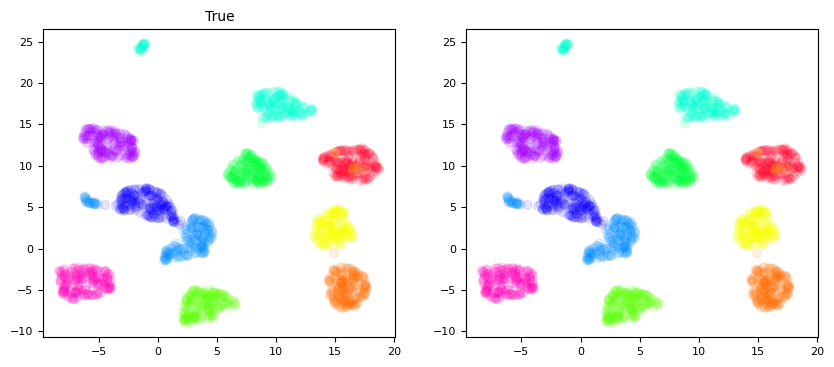

In [57]:
cont_test_umap = learn_manifold_umap(cont_reps_test, umap_dim=2, umap_min_dist=0.5, umap_metric='euclidean', umap_neighbors=10)

# X = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=100).fit_transform(cont_reps_test)
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = cont_test_umap
# gmm = gmm_list_cont[-1]
# train_labels = gmm.predict(cont_reps_train)
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
# gmm_cont_test_labels = gmm.predict(cont_reps_test)
# score = adjusted_rand_score(labels_test, labels_test_ms)*100
axes[0].set_title('True')
# axes[1].set_title(f'Predicted, rand_score: {score}');

Text(0.5, 1.0, 'True')

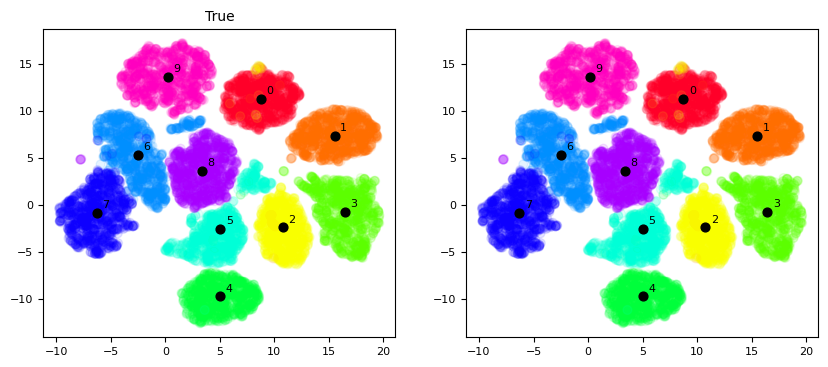

In [61]:
cont_test_umap = learn_manifold_umap(cont_reps_train, umap_dim=2, umap_min_dist=0.5, umap_metric='euclidean', umap_neighbors=10)

# X = TSNE(n_components=2, learning_rate='auto',
#                   init='random', perplexity=100).fit_transform(cont_reps_test)
fig, axes = plt.subplots(1,2,figsize=(10,4))
X = cont_test_umap
# gmm = gmm_list_cont[-1]
# train_labels = gmm.predict(cont_reps_train)
annotate_offset=.5
axes[0].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
axes[1].scatter(X[:, 0], X[:, 1], c=labels_train, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_train))):
    mean_location = np.mean(X[np.where(labels_train==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
    
for label_plot in range(len(np.unique(labels_train))):
    mean_location = np.mean(X[np.where(labels_train==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))

# plot_gmm(gmm, wfs_train_cont_numpy, label=True, ax=axes[1])
# gmm_cont_test_labels = gmm.predict(cont_reps_test)
# score = adjusted_rand_score(labels_test, labels_test_ms)*100
axes[0].set_title('True')
# axes[1].set_title(f'Predicted, rand_score: {score}');

In [ ]:
# labels_plot = [7, 5] #labels to plot
# labels = labels_train #all labels
# X_plot = pcs_train_cont #plot these reps
# plot_feature = 'cont pc'
# X_dist = cont_reps_train #compute dist on these reps
# wfs_plot = wfs_train #plot these waveforms 
# close_to = 1 #closest points to index 1 label
# num_spikes = 4 #num spikes to plot

# plot_closest_spikes(X_plot, X_dist, wfs_plot, labels, labels_plot, plot_feature, annotate_offset = .05, close_to=close_to, num_spikes=num_spikes)

Text(0, 0.5, 'raw pc2')

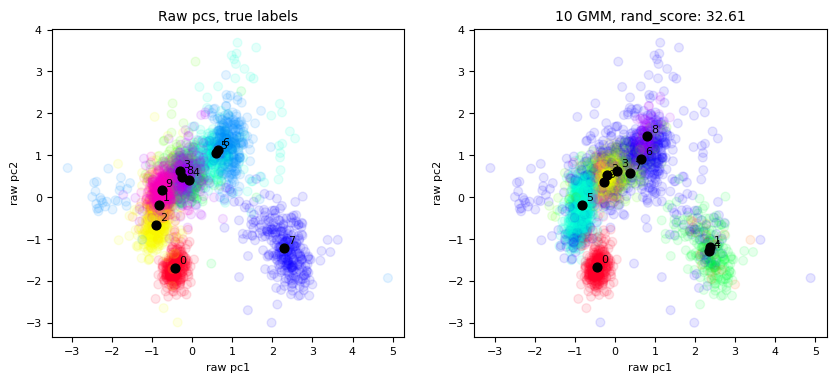

In [64]:
X = pcs_test
labels_pred = pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw pcs, true labels')
axes[0].set_xlabel('raw pc1')
axes[0].set_ylabel('raw pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('raw pc1')
axes[1].set_ylabel('raw pc2')

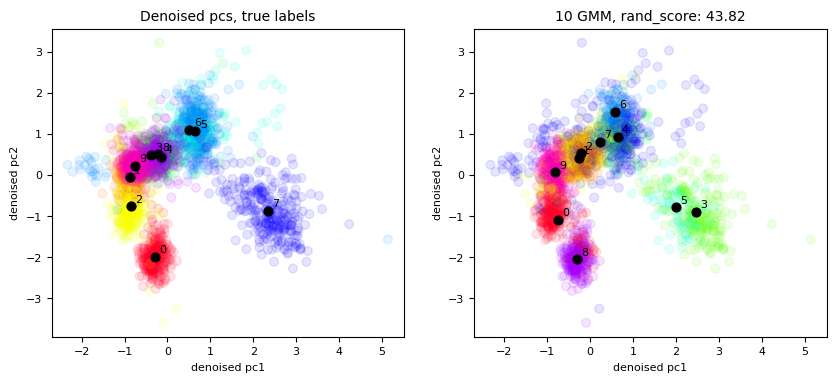

In [65]:
X = denoised_pcs_test
labels_pred = denoised_pc_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Denoised pcs, true labels')
axes[0].set_xlabel('denoised pc1')
axes[0].set_ylabel('denoised pc2')
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}')
axes[1].set_xlabel('denoised pc1')
axes[1].set_ylabel('denoised pc2');

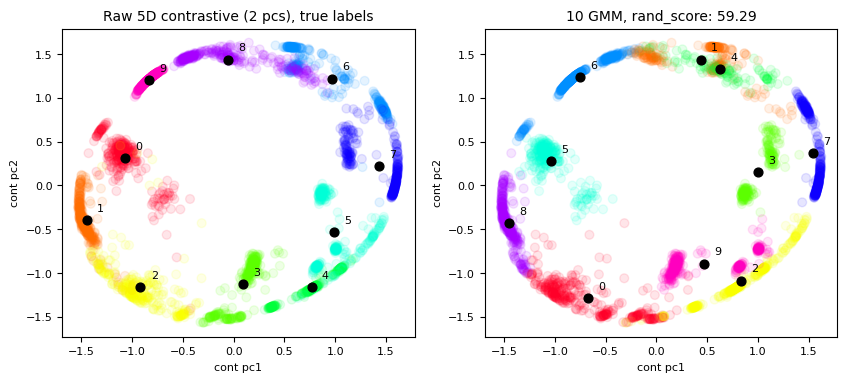

In [66]:
X = pcs_test_cont
labels_pred = gmm_cont_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');

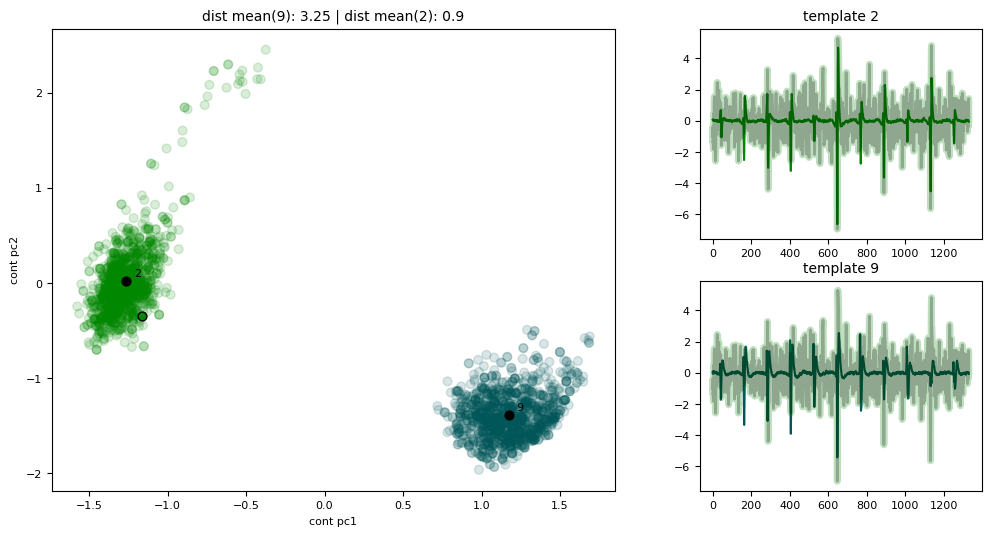

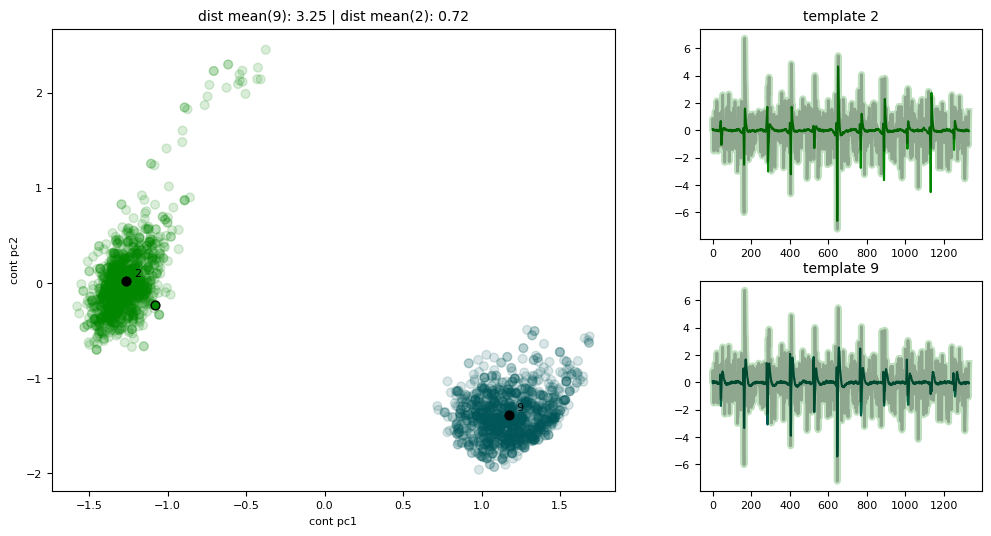

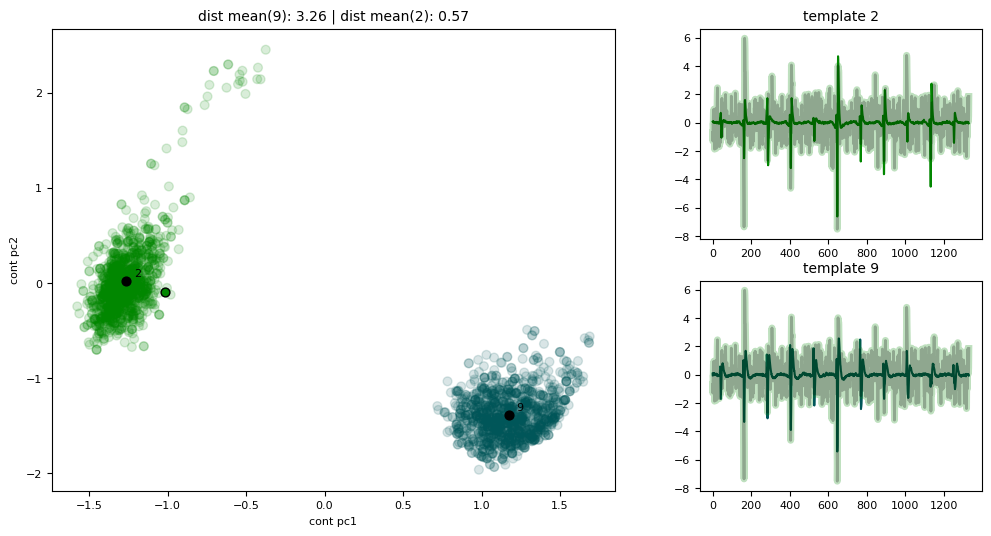

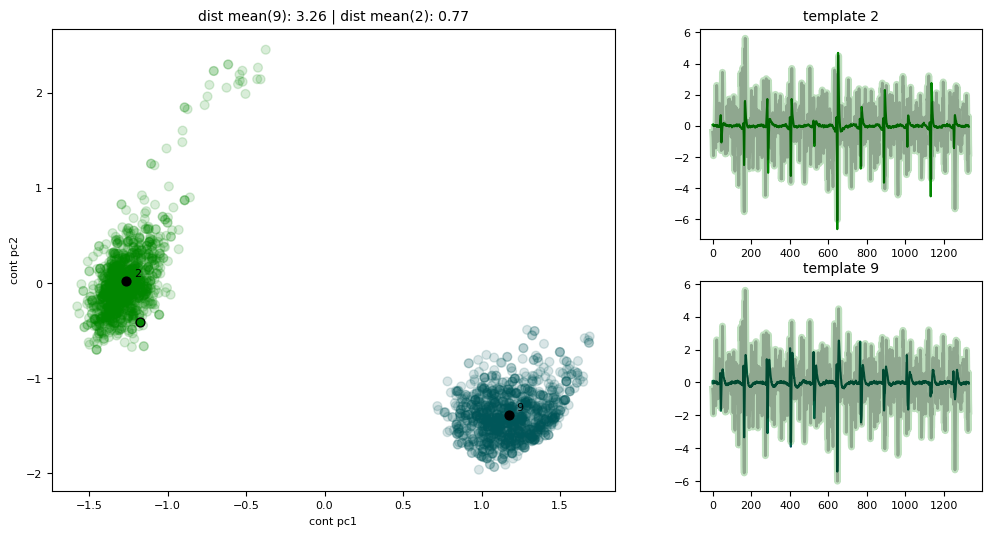

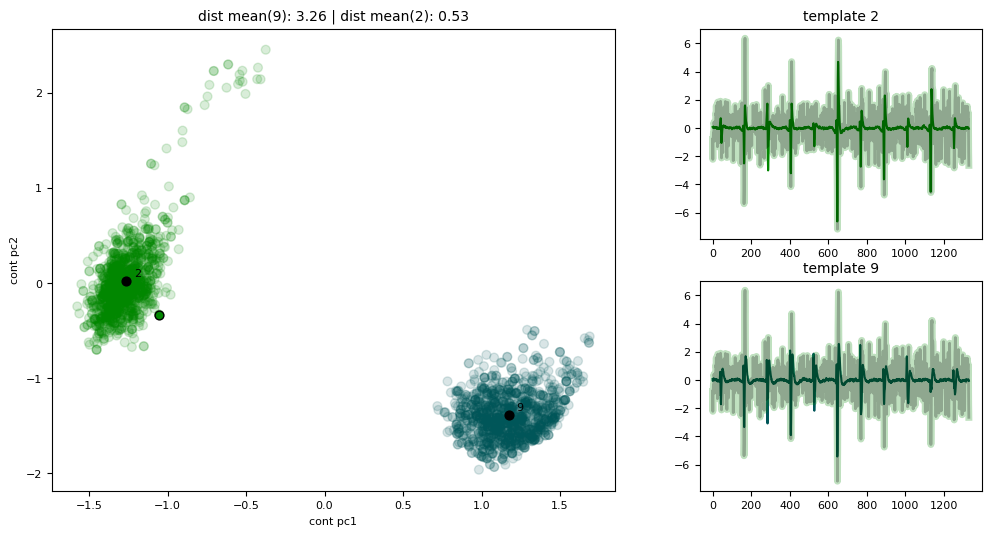

IndexError: index 5 is out of bounds for axis 0 with size 5

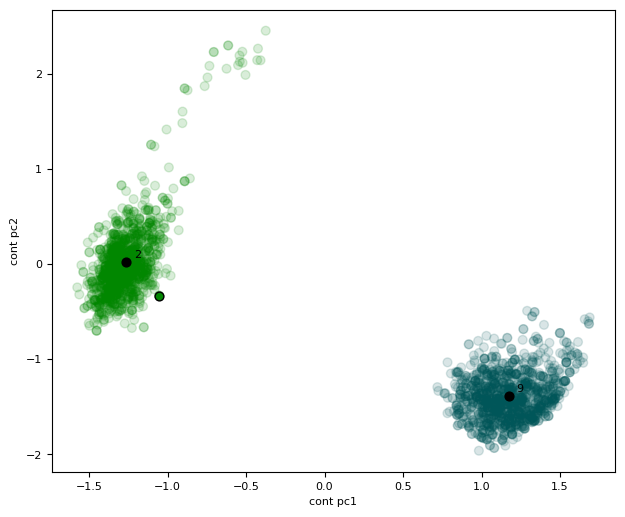

In [41]:
labels_plot = [2, 9] #labels to plot
labels = labels_train #all labels
X_plot = pcs_train_cont #plot these reps
plot_feature = 'cont pc'
X_dist = cont_reps_train #compute dist on these reps
wfs_plot = wfs_train #plot these waveforms 
close_to = 1 #closest points to index 1 label
num_spikes = 20 #num spikes to plot
alpha = .15

plot_closest_spikes(X_plot, X_dist, wfs_plot, labels, labels_plot, plot_feature, annotate_offset = .05, close_to=close_to, num_spikes=num_spikes, alpha=alpha)

# X_plot = denoised_pcs_train_pcs #plot these reps
# plot_feature = 'denoised pc'
# plot_closest_spikes(X_plot, X_dist, wfs_plot, labels, labels_plot, plot_feature, annotate_offset = .05, close_to=close_to, num_spikes=num_spikes)

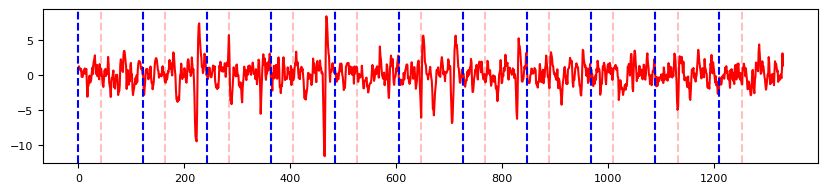

In [54]:
plt.figure(figsize=(10,2))
# plt.plot(wfs_train[labels_train==2][306].flatten())
plt.plot(wfs_train[labels_train==2][306].flatten(), color='red')
# Plot vertical lines at every 121 x steps
for i in range(0, len(wfs_train[labels_train==2][306].flatten()), 121):
    plt.axvline(i, color='blue', linestyle='--')
for i in range(0, len(wfs_train[labels_train==2][306].flatten()), 121):
    plt.axvline(i+42, color='red', linestyle='--', alpha=.25)

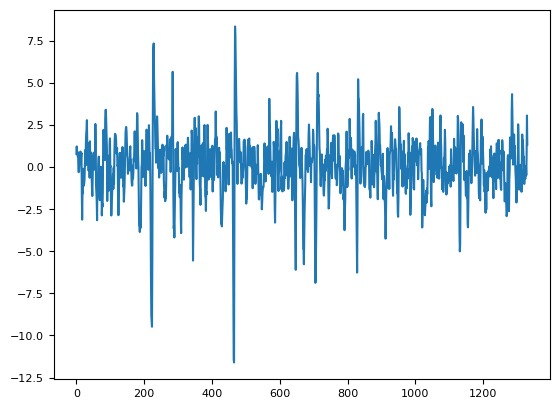

In [50]:
plt.plot(wfs_train[labels_train==2][306].flatten())
# unit_id = 0
# max1 = 10
# max2 = 8
# idx1=np.where(labels_train==unit_id)[0][np.where(channel_num_train[:,0][labels_train==unit_id]==max1)[0][0]]
# for i in range(200):
#     idx2=np.where(labels_train==unit_id)[0][np.where(channel_num_train[:,0][labels_train==unit_id]==max2)[0][i]]
#     plt.figure(figsize=(14,2))
#     plt.plot(spikes_train[idx1].flatten(), lw=5)
#     plt.plot(spikes_train[idx2].flatten(), color='red')
#     # Plot vertical lines at every 121 x steps
#     for i in range(0, len(spikes_train[idx1].flatten()), 121):
#         plt.axvline(i, color='red', linestyle='--')
#     for i in range(0, len(spikes_train[idx1].flatten()), 121):
#         plt.axvline(i+42, color='blue', linestyle='--', alpha=.25)
#     print("channel num 1st",channel_num_train[idx1])
#     print("channel num 1st",channel_num_train[idx2])
#     print("old loc 1st",channel_spike_locs_train[idx1][0])
#     print("old loc 1st",channel_spike_locs_train[idx2][0])
#     print("channel num loc 1st", geom[channel_num_train[idx1][0].astype('int')])
#     print("channel num loc 1st", geom[channel_num_train[idx2][0].astype('int')])
#     print("new loc 1st", channel_spike_locs_train_new[idx1][0].astype('int'))
#     print("new loc 1st", channel_spike_locs_train_new[idx2][0].astype('int'))
#     plt.show()

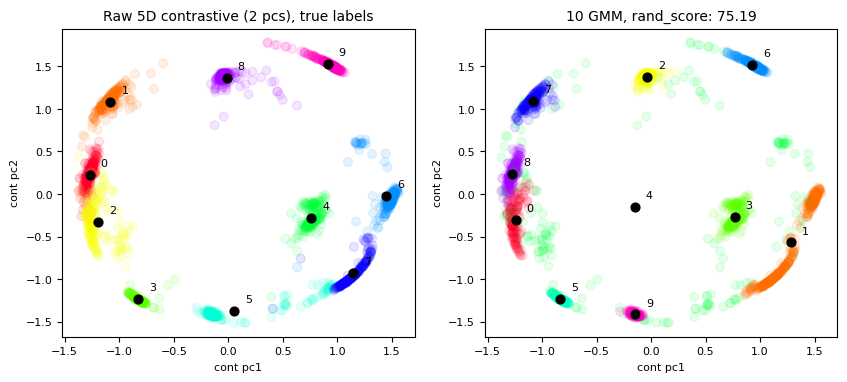

In [65]:
X = pcs_test_cont
labels_pred = gmm_cont_test_labels
annotate_offset = .1
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_test))):
    mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
    axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
axes[0].set_title('Raw 5D contrastive (2 pcs), true labels')
axes[0].set_xlabel('cont pc1')
axes[0].set_ylabel('cont pc2');
axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
for label_plot in range(len(np.unique(labels_pred))):
    mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
    axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
    axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
score = adjusted_rand_score(labels_test, labels_pred)*100
axes[1].set_title(f'10 GMM, rand_score: {np.round(score,decimals=2)}');
axes[1].set_xlabel('cont pc1')
axes[1].set_ylabel('cont pc2');

In [68]:
# X = cont_test_umap
# labels_pred = labels_test_ms
# annotate_offset = .5
# fig, axes = plt.subplots(1,2,figsize=(10,4))
# axes[0].scatter(X[:, 0], X[:, 1], c=labels_test, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
# for label_plot in range(len(np.unique(labels_test))):
#     mean_location = np.mean(X[np.where(labels_test==label_plot)],0)
#     axes[0].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
#     axes[0].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
# axes[0].set_title('Raw 5D contrastive (2 umap)')
# axes[0].set_xlabel('umap1')
# axes[0].set_ylabel('umap2');
# axes[1].scatter(X[:, 0], X[:, 1], c=labels_pred, s=40, cmap='gist_rainbow', zorder=2, alpha=.1)
# for label_plot in range(len(np.unique(labels_pred))):
#     mean_location = np.mean(X[np.where(labels_pred==label_plot)],0)
#     axes[1].scatter(mean_location[0], mean_location[1],color='black', alpha=1, s=40, zorder=2)
#     axes[1].annotate(f'{label_plot}', (mean_location[0]+annotate_offset, mean_location[1]+annotate_offset))
# score = adjusted_rand_score(labels_test, labels_pred)*100
# axes[1].set_title(f'Meanshift, rand_score: {score}');
# axes[1].set_xlabel('umap1')
# axes[1].set_ylabel('umap2');